# Extending our PyTorch containers

With Amazon SageMaker, you can package your own algorithms that can then be trained and deployed in the SageMaker environment. This notebook guides you through an example on how to extend one of our existing and predefined SageMaker deep learning framework containers.

By packaging an algorithm in a container, you can bring almost any code to the Amazon SageMaker environment, regardless of programming language, environment, framework, or dependencies. 

1. [Extending our PyTorch containers](#Extending-our-pytorch-containers)
  1. [When should I extend a SageMaker container?](#When-should-I-extend-a-SageMaker-container?)
  1. [Permissions](#Permissions)
  1. [The example](#The-example)
  1. [The presentation](#The-presentation)
1. [Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker](#Part-1:-Packaging-and-Uploading-your-Algorithm-for-use-with-Amazon-SageMaker)
    1. [An overview of Docker](#An-overview-of-Docker)
    1. [How Amazon SageMaker runs your Docker container](#How-Amazon-SageMaker-runs-your-Docker-container)
      1. [Running your container during training](#Running-your-container-during-training)
        1. [The input](#The-input)
        1. [The output](#The-output)
      1. [Running your container during hosting](#Running-your-container-during-hosting)
    1. [The parts of the sample container](#The-parts-of-the-sample-container)
    1. [The Dockerfile](#The-Dockerfile)
    1. [Building and registering the container](#Building-and-registering-the-container)
  1. [Testing your algorithm on your local machine](#Testing-your-algorithm-on-your-local-machine)
  1. [Download the Oxford Pets dataset](#Download-the-CIFAR-10-dataset)
  1. [SageMaker Python SDK Local Training](#SageMaker-Python-SDK-Local-Training)
  1. [Fit, Deploy, Predict](#Fit,-Deploy,-Predict)
  1. [Making predictions using Python SDK](#Making-predictions-using-Python-SDK)
1. [Part 2: Training and Hosting your Algorithm in Amazon SageMaker](#Part-2:-Training-and-Hosting-your-Algorithm-in-Amazon-SageMaker)
  1. [Set up the environment](#Set-up-the-environment)
  1. [Create the session](#Create-the-session)
  1. [Upload the data for training](#Upload-the-data-for-training)
  1. [Training On SageMaker](#Training-on-SageMaker)
  1. [Optional cleanup](#Optional-cleanup)  
1. [Reference](#Reference)

_or_ I'm impatient, just [let me see the code](#The-Dockerfile)!

## When should I extend a SageMaker container?

You may not need to create a container to bring your own code to Amazon SageMaker. When you are using a framework such as [TensorFlow](https://github.com/aws/sagemaker-tensorflow-container), [MXNet](https://github.com/aws/sagemaker-mxnet-container), [PyTorch](https://github.com/aws/sagemaker-pytorch-container) or [Chainer](https://github.com/aws/sagemaker-chainer-container) that has direct support in SageMaker, you can simply supply the Python code that implements your algorithm using the SDK entry points for that framework.

Even if there is direct SDK support for your environment or framework, you may want to add additional functionality or configure your container environment differently while utilizing our container to use on SageMaker.

**Some of the reasons to extend a SageMaker deep learning framework container are:**
1. Install additional dependencies. (E.g. I want to install a specific Python library, that the current SageMaker containers don't install.)
2. Configure your environment. (E.g. I want to add an environment variable to my container.)

**Although it is possible to extend any of our framework containers as a parent image, the example this notebook covers is currently only intended to work with our PyTorch (0.4.0+) and Chainer (4.1.0+) containers.**

This walkthrough shows that it is quite straightforward to extend one of our containers to build your own custom container for PyTorch or Chainer.

## Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because it creates new repositories in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

## The example

In this example we show how to package a PyTorch container, extending the SageMaker PyTorch container, with a Python example which works with the Oxford Pets dataset. By extending the SageMaker PyTorch container we can utilize the existing training and hosting solution made to work on SageMaker. By comparison, if one were to build their own custom framework container from scratch, they would need to implement a training and hosting solution in order to use SageMaker. Here is an example showing [how to create a SageMaker TensorFlow container from scratch](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/tensorflow_bring_your_own/tensorflow_bring_your_own.ipynb).

In this example, we use a single image to support training and hosting. This simplifies the procedure because we only need to manage one image for both tasks. Sometimes you may want separate images for training and hosting because they have different requirements. In this case, separate the parts discussed below into separate Dockerfiles and build two images. Choosing whether to use a single image or two images is a matter of what is most convenient for you to develop and manage.

If you're only using Amazon SageMaker for training or hosting, but not both, only the functionality used needs to be built into your container.

[CIFAR-10]: http://www.cs.toronto.edu/~kriz/cifar.html

## The presentation

This presentation is divided into two parts: _building_ the container and _using_ the container.

# Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker

### An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new technology. But they are not difficult and can significantly simplify the deployment of your software packages. 

Docker provides a simple way to package arbitrary code into an _image_ that is totally self-contained. Once you have an image, you can use Docker to run a _container_ based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way your program is set up is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, and environment variable.

A Docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run simultaneously on the same physical or virtual machine instance.

Docker uses a simple file called a `Dockerfile` to specify how the image is assembled. An example is provided below. You can build your Docker images based on Docker images built by yourself or by others, which can simplify things quite a bit.

Docker has become very popular in programming and devops communities due to its flexibility and its well-defined specification of how code can be run in its containers. It is the underpinning of many services built in the past few years, such as [Amazon ECS].

Amazon SageMaker uses Docker to allow users to train and deploy arbitrary algorithms.

In Amazon SageMaker, Docker containers are invoked in a one way for training and another, slightly different, way for hosting. The following sections outline how to build containers for the SageMaker environment.

Some helpful links:

* [Docker home page](http://www.docker.com)
* [Getting started with Docker](https://docs.docker.com/get-started/)
* [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
* [`docker run` reference](https://docs.docker.com/engine/reference/run/)

[Amazon ECS]: https://aws.amazon.com/ecs/

### How Amazon SageMaker runs your Docker container

Because you can run the same image in training or hosting, Amazon SageMaker runs your container with the argument `train` or `serve`. How your container processes this argument depends on the container. All SageMaker deep learning framework containers already cover this requirement and will trigger your defined training algorithm and inference code.

* If you specify a program as an `ENTRYPOINT` in the Dockerfile, that program will be run at startup and its first argument will be `train` or `serve`. The program can then look at that argument and decide what to do. The original `ENTRYPOINT` specified within the SageMaker PyTorch is [here](https://github.com/aws/sagemaker-pytorch-container/blob/master/docker/0.4.0/final/Dockerfile.cpu#L18).

#### Running your container during training

Currently, our SageMaker PyTorch container utilizes [console_scripts](http://python-packaging.readthedocs.io/en/latest/command-line-scripts.html#the-console-scripts-entry-point) to make use of the `train` command issued at training time. The line that gets invoked during `train` is defined within the setup.py file inside [SageMaker Containers](https://github.com/aws/sagemaker-containers/blob/master/setup.py#L48), our common SageMaker deep learning container framework. When this command is run, it will invoke the [trainer class](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/cli/train.py) to run, which will finally invoke our [PyTorch container code](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/training.py) to run your Python file.

A number of files are laid out for your use, under the `/opt/ml` directory:

    /opt/ml
    |-- input
    |   |-- config
    |   |   |-- hyperparameters.json
    |   |   `-- resourceConfig.json
    |   `-- data
    |       `-- <channel_name>
    |           `-- <input data>
    |-- model
    |   `-- <model files>
    `-- output
        `-- failure

##### The input

* `/opt/ml/input/config` contains information to control how your program runs. `hyperparameters.json` is a JSON-formatted dictionary of hyperparameter names to values. These values are always strings, so you may need to convert them. `resourceConfig.json` is a JSON-formatted file that describes the network layout used for distributed training.
* `/opt/ml/input/data/<channel_name>/` (for File mode) contains the input data for that channel. The channels are created based on the call to CreateTrainingJob but it's generally important that channels match algorithm expectations. The files for each channel are copied from S3 to this directory, preserving the tree structure indicated by the S3 key structure. 
* `/opt/ml/input/data/<channel_name>_<epoch_number>` (for Pipe mode) is the pipe for a given epoch. Epochs start at zero and go up by one each time you read them. There is no limit to the number of epochs that you can run, but you must close each pipe before reading the next epoch.

##### The output

* `/opt/ml/model/` is the directory where you write the model that your algorithm generates. Your model can be in any format that you want. It can be a single file or a whole directory tree. SageMaker packages any files in this directory into a compressed tar archive file. This file is made available at the S3 location returned in the `DescribeTrainingJob` result.
* `/opt/ml/output` is a directory where the algorithm can write a file `failure` that describes why the job failed. The contents of this file are returned in the `FailureReason` field of the `DescribeTrainingJob` result. For jobs that succeed, there is no reason to write this file as it is ignored.

#### Running your container during hosting

Hosting has a very different model than training because hosting is reponding to inference requests that come in via HTTP. Currently, the SageMaker PyTorch containers [uses](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/serving.py#L103) our [recommended Python serving stack](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/_server.py#L44) to provide robust and scalable serving of inference requests:

![Request serving stack](stack.png)

Amazon SageMaker uses two URLs in the container:

* `/ping` receives `GET` requests from the infrastructure. Your program returns 200 if the container is up and accepting requests.
* `/invocations` is the endpoint that receives client inference `POST` requests. The format of the request and the response is up to the algorithm. If the client supplied `ContentType` and `Accept` headers, these are passed in as well. 

The container has the model files in the same place that they were written to during training:

    /opt/ml
    `-- model
        `-- <model files>



### The parts of the sample container

The `container` directory has all the components you need to extend the SageMaker PyTorch container to use as an sample algorithm:

    .
    |-- Dockerfile
    |-- build_and_push.sh
    `-- oxford-pets
        `-- oxford-pets.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. More details are provided below.
* __`build_and_push.sh`__ is a script that uses the Dockerfile to build your container images and then pushes it to ECR. We invoke the commands directly later in this notebook, but you can just copy and run the script for your own algorithms.
* __`oxford-pets`__ is the directory which contains our user code to be invoked.

In this simple application, we install only one file in the container. You may only need that many, but if you have many supporting routines, you may wish to install more.

The files that we put in the container are:

* __`oxford-pets.py`__ is the program that implements our training algorithm and handles loading our model for inferences.

### The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

We start from the SageMaker PyTorch image as the base. The base image is an ECR image, so it will have the following pattern.
* {account}.dkr.ecr.{region}.amazonaws.com/sagemaker-{framework}:{framework_version}-{processor_type}-{python_version}

Here is an explanation of each field.
1. account - AWS account ID the ECR image belongs to. Our public deep learning framework images are all under the 520713654638 account.
2. region - The region the ECR image belongs to. [Available regions](https://aws.amazon.com/about-aws/global-infrastructure/regional-product-services/).
3. framework - The deep learning framework.
4. framework_version - The version of the deep learning framework.
5. processor_type - CPU or GPU.
6. python_version - The supported version of Python.

So the SageMaker PyTorch ECR image would be:
520713654638.dkr.ecr.us-west-2.amazonaws.com/sagemaker-pytorch:0.4.0-cpu-py3

Information on supported frameworks and versions can be found in this [README](https://github.com/aws/sagemaker-python-sdk).

Next, we add the code that implements our specific algorithm to the container and set up the right environment for it to run under.

**DISCLAIMER: As of now, the support for the two environment variables below are only supported for the SageMaker Chainer (4.1.0+) and PyTorch (0.4.0+) containers.**

Finally, we need to specify two environment variables.
1. SAGEMAKER_SUBMIT_DIRECTORY - the directory within the container containing our Python script for training and inference.
2. SAGEMAKER_PROGRAM - the Python script that should be invoked for training and inference.

Let's look at the Dockerfile for this example.

In [ ]:
!cat container/Dockerfile

### Building and registering the container

The following shell code shows how to build the container image using `docker build` and push the container image to ECR using `docker push`. This code is also available as the shell script `container/build-and-push.sh`, which you can run as `build-and-push.sh fastai2-oxford-pets-sagemaker-example` to build the image `fastai2-oxford-pets-sagemaker-example`. 

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this is the region where the notebook instance was created). If the repository doesn't exist, the script will create it. In addition, since we are using the SageMaker PyTorch image as the base, we will need to retrieve ECR credentials to pull this public image.

In [ ]:
%%sh

# The name of our algorithm
image=fastai2-oxford-pets-sagemaker-example

cd container

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${image}"
echo "Creating Docker image name is ${fullname}"

for repo in ${image}-training ${image}-inference
do
    # If the repository doesn't exist in ECR, create it.
    aws ecr describe-repositories --repository-names "${repo}" > /dev/null 2>&1

    if [ $? -ne 0 ]
    then
        echo "Creating ECR repo with name ${repo}"
        aws ecr create-repository --repository-name "${repo}" > /dev/null
    fi
done


# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Get the login command from ECR in order to pull down the SageMaker PyTorch image
$(aws ecr get-login --registry-ids 763104351884 --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
docker build -t ${image}-inference . --build-arg REGION=${region} --build-arg ARCH=cpu --build-arg TYPE=inference --build-arg CUDA_VERSION=""
docker build -t ${image}-training . --build-arg REGION=${region} --build-arg ARCH=gpu --build-arg TYPE=training --build-arg CUDA_VERSION="-cu101"

docker tag ${image}-inference ${fullname}-inference
docker tag ${image}-training ${fullname}-training

docker push ${fullname}-inference
docker push ${fullname}-training

## Testing your algorithm on your local machine

When you're packaging your first algorithm to use with Amazon SageMaker, you probably want to test it yourself to make sure it's working correctly. We use the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) to test both locally and on SageMaker. For more examples with the SageMaker Python SDK, see [Amazon SageMaker Examples](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-python-sdk). In order to test our algorithm, we need our dataset.

## Install the fast.ai v2 libraries and download training dataset
We will be utilizing the Oxford Pets dataset that is available from the fastai v2 library.

In [1]:
! pip install feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore
! pip install torchvision==0.4.2 --upgrade
! pip install Pillow==6.2.1 --upgrade

    100% |████████████████████████████████| 143kB 9.9MB/s ta 0:00:01
    100% |████████████████████████████████| 62.9MB 783kB/s eta 0:00:01  5% |█▋                              | 3.2MB 60.2MB/s eta 0:00:01
    100% |████████████████████████████████| 1.4MB 29.7MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 31.5MB/s ta 0:00:01
    100% |████████████████████████████████| 184kB 45.4MB/s ta 0:00:01
    100% |████████████████████████████████| 2.1MB 24.8MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 39.6MB/s ta 0:00:01
    100% |████████████████████████████████| 460kB 40.4MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 41.8MB/s a 0:00:01
    100% |████████████████████████████████| 102kB 37.8MB/s a 0:00:01
  Using cached https://files.pythonhosted.org/packages/32/c8/564be4d12629b912ea431f1a50eb8b3b9d00f1a0b1ceff17f266be190007/subprocess32-3.5.4.tar.gz
    100% |████████████████████████████████| 460kB 31.4MB/s ta 0:00:01
    100% |██████████

    100% |████████████████████████████████| 71kB 26.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for feather-format ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/85/7d/12/2dfa5c0195f921ac935f5e8f27deada74972edc0ae9988a9c1
  Running setup.py bdist_wheel for watchdog ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/bc/ed/6c/028dea90d31b359cd2a7c8b0da4db80e41d24a59614154072e
  Running setup.py bdist_wheel for nvidia-ml-py3 ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
  Running setup.py bdist_wheel for subprocess32 ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Running setup.py bdist_wheel for gql ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Running setup.py bdist_wheel for pathtools ... done
  Stored in directory:

  Found existing installation: nbconvert 5.4.1
    Uninstalling nbconvert-5.4.1:
      Successfully uninstalled nbconvert-5.4.1
  Found existing installation: torchvision 0.4.2
    Uninstalling torchvision-0.4.2:
      Successfully uninstalled torchvision-0.4.2
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 10.2MB 4.7MB/s eta 0:00:01   14% |████▋                           | 1.5MB 48.4MB/s eta 0:00:01
Requirement not upgraded as not directly required: six in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from torchvision==0.4.2) (1.11.0)
Requirement not upgraded as not directly required: pillow>=4.1.1 in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from torchvision==0.4.2) (7.0.0)
Requirement not upgraded as not directly required: numpy in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/si

In [2]:
from fastai2.vision.all import *

In [3]:
path = untar_data(URLs.PETS); path

Path('/home/ec2-user/.fastai/data/oxford-iiit-pet')

In [4]:
# There should be the Oxford Pets images and annotations dirs)
path.ls()

(#2) [Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/images'),Path('/home/ec2-user/.fastai/data/oxford-iiit-pet/annotations')]

## SageMaker Python SDK Local Training
To represent our training, we use the Estimator class, which needs to be configured in five steps. 
1. IAM role - our AWS execution role
2. train_instance_count - number of instances to use for training.
3. train_instance_type - type of instance to use for training. For training locally, we specify `local` or `local_gpu`.
4. image_name - our custom PyTorch Docker image we created.
5. hyperparameters - hyperparameters we want to pass.

Let's start with setting up our IAM role. We make use of a helper function within the Python SDK. This function throw an exception if run outside of a SageMaker notebook instance, as it gets metadata from the notebook instance. If running outside, you must provide an IAM role with proper access stated above in [Permissions](#Permissions).

In [14]:
from sagemaker import get_execution_role

role = get_execution_role()

## Fit, Deploy, Predict

Now that the rest of our estimator is configured, we can call `fit()` with the path to our local Oxford Pets dataset prefixed with `file://`. This invokes our PyTorch container with 'train' and passes in our hyperparameters and other metadata as json files in /opt/ml/input/config within the container to our program entry point defined in the Dockerfile.

After our training has succeeded, our training algorithm outputs our trained model within the /opt/ml/model directory, which is used to handle predictions.

We can then call `deploy()` with an instance_count and instance_type, which is 1 and `local`. This invokes our PyTorch container with 'serve', which setups our container to handle prediction requests as defined [here](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/serving.py#L103). What is returned is a predictor, which is used to make inferences against our trained model.

After our prediction, we can delete our endpoint.

We recommend testing and training your training algorithm locally first, as it provides quicker iterations and better debuggability.

In [ ]:
# Lets set up our SageMaker notebook instance for local mode.
!/bin/bash ./utils/setup.sh

In [15]:
import os
import subprocess

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    ## Set type to GPU if one is present
    instance_type = 'local_gpu'
    
print("Instance type = " + instance_type)

Instance type = local_gpu


In [ ]:
#from sagemaker.estimator import Estimator

#hyperparameters = {'epochs': 8}

#estimator = Estimator(role=role,
#                      train_instance_count=1,
#                      train_instance_type='local_gpu',
#                      image_name='fastai2-oxford-pets-sagemaker-example-training',
#                      hyperparameters=hyperparameters)

#estimator.fit('file://' + str(path))

In [17]:
from sagemaker.pytorch import PyTorch 

hyperparameters = {'epochs': 2}

estimator = PyTorch(source_dir='container/oxford-pets',
                    entry_point='oxford-pets.py',
                    role=role,
                    train_instance_count=1,
                    train_instance_type='local_gpu',
                    framework_version='1.3.1',
                    hyperparameters=hyperparameters,
                    image_name='fastai2-oxford-pets-sagemaker-example-training')

estimator.fit('file://' + str(path))

Creating tmpaq34mu66_algo-1-875gm_1 ... 
Attaching to tmpaq34mu66_algo-1-875gm_12mdone
algo-1-875gm_1  | 2020-03-15 13:30:25,119 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
algo-1-875gm_1  | 2020-03-15 13:30:25,143 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
algo-1-875gm_1  | 2020-03-15 13:30:25,145 sagemaker_pytorch_container.training INFO     Invoking user training script.
algo-1-875gm_1  | 2020-03-15 13:30:25,269 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
algo-1-875gm_1  | Generating setup.py
algo-1-875gm_1  | 2020-03-15 13:30:25,269 sagemaker-containers INFO     Generating setup.cfg
algo-1-875gm_1  | 2020-03-15 13:30:25,269 sagemaker-containers INFO     Generating MANIFEST.in
algo-1-875gm_1  | 2020-03-15 13:30:25,269 sagemaker-containers INFO     Installing module with the following command:
algo-1-875gm_1  | /opt/conda/bin/python -m pip install . 


1         0.350635    0.203083    0.060217    00:24     
algo-1-875gm_1  | INFO:__main__:Finished training
algo-1-875gm_1  | INFO:__main__:Saving the model.
algo-1-875gm_1  | INFO:__main__:Model saved
algo-1-875gm_1  | 2020-03-15 13:31:33,689 sagemaker-containers INFO     Reporting training SUCCESS
tmpaq34mu66_algo-1-875gm_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


In [18]:
model = estimator.create_model(role=role, 
                               entry_point='oxford-pets.py', 
                               source_dir='container/oxford-pets')

In [19]:
model.image = 'fastai2-oxford-pets-sagemaker-example-inference'

In [20]:
predictor = model.deploy(1, 'local')

Attaching to tmpvuioviy4_algo-1-e4rhk_1
algo-1-e4rhk_1  | 2020-03-15 13:33:45,822 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
algo-1-e4rhk_1  | MMS Home: /opt/conda/lib/python3.6/site-packages
algo-1-e4rhk_1  | Current directory: /
algo-1-e4rhk_1  | Temp directory: /home/model-server/tmp
algo-1-e4rhk_1  | Number of GPUs: 0
algo-1-e4rhk_1  | Number of CPUs: 8
algo-1-e4rhk_1  | Max heap size: 13646 M
algo-1-e4rhk_1  | Python executable: /opt/conda/bin/python
algo-1-e4rhk_1  | Config file: /etc/sagemaker-mms.properties
algo-1-e4rhk_1  | Inference address: http://0.0.0.0:8080
algo-1-e4rhk_1  | Management address: http://0.0.0.0:8080
algo-1-e4rhk_1  | Model Store: /.sagemaker/mms/models
algo-1-e4rhk_1  | Initial Models: ALL
algo-1-e4rhk_1  | Log dir: /logs
algo-1-e4rhk_1  | Metrics dir: /logs
algo-1-e4rhk_1  | Netty threads: 0
algo-1-e4rhk_1  | Netty client threads: 0
algo-1-e4rhk_1  | Default workers per model: 8
algo-1-e4rhk_1  | Blacklist Regex: N/A
algo-1-e4rhk_1  | Maximum Respons

algo-1-e4rhk_1  | 2020-03-15 13:33:46,599 [INFO ] W-9005-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 413
algo-1-e4rhk_1  | 2020-03-15 13:33:46,599 [INFO ] W-9007-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 414
algo-1-e4rhk_1  | 2020-03-15 13:33:46,607 [INFO ] W-9006-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 438
algo-1-e4rhk_1  | 2020-03-15 13:33:46,615 [INFO ] W-9002-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 454
algo-1-e4rhk_1  | 2020-03-15 13:33:46,617 [INFO ] W-9001-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 454
algo-1-e4rhk_1  | 2020-03-15 13:33:46,623 [INFO ] W-9003-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 454
algo-1-e4rhk_1  | 2020-03-15 13:33:46,626 [INFO ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 461
algo-1-e4rhk_1  | 2020-03-15 13:33:46,635 [INFO ] W-9004-model com.amazonaws.ml.mms.wlm.Wo

In [11]:
#predictor = estimator.deploy(1, 'local', image='fastai2-oxford-pets-sagemaker-example-inference')

Attaching to tmpcrgva5c5_algo-1-xu1rq_1
algo-1-xu1rq_1  | 2020-03-10 18:01:56,690 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
algo-1-xu1rq_1  | MMS Home: /opt/conda/lib/python3.6/site-packages
algo-1-xu1rq_1  | Current directory: /
algo-1-xu1rq_1  | Temp directory: /home/model-server/tmp
algo-1-xu1rq_1  | Number of GPUs: 0
algo-1-xu1rq_1  | Number of CPUs: 8
algo-1-xu1rq_1  | Max heap size: 13646 M
algo-1-xu1rq_1  | Python executable: /opt/conda/bin/python
algo-1-xu1rq_1  | Config file: /etc/sagemaker-mms.properties
algo-1-xu1rq_1  | Inference address: http://0.0.0.0:8080
algo-1-xu1rq_1  | Management address: http://0.0.0.0:8080
algo-1-xu1rq_1  | Model Store: /.sagemaker/mms/models
algo-1-xu1rq_1  | Initial Models: ALL
algo-1-xu1rq_1  | Log dir: /logs
algo-1-xu1rq_1  | Metrics dir: /logs
algo-1-xu1rq_1  | Netty threads: 0
algo-1-xu1rq_1  | Netty client threads: 0
algo-1-xu1rq_1  | Default workers per model: 8
algo-1-xu1rq_1  | Blacklist Regex: N/A
algo-1-xu1rq_1  | Maximum Respons

algo-1-xu1rq_1  | 2020-03-10 18:01:57,481 [INFO ] W-9002-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 416
algo-1-xu1rq_1  | 2020-03-10 18:01:57,485 [INFO ] W-9004-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 416
algo-1-xu1rq_1  | 2020-03-10 18:01:57,488 [INFO ] W-9006-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 446
algo-1-xu1rq_1  | 2020-03-10 18:01:57,494 [INFO ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 452
algo-1-xu1rq_1  | 2020-03-10 18:01:57,501 [INFO ] W-9001-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 432
algo-1-xu1rq_1  | 2020-03-10 18:01:57,503 [INFO ] W-9005-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 458
algo-1-xu1rq_1  | 2020-03-10 18:01:57,503 [INFO ] W-9007-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 434
algo-1-xu1rq_1  | 2020-03-10 18:01:57,509 [INFO ] W-9003-model com.amazonaws.ml.mms.wlm.Wo

## Making predictions using Python SDK

To make predictions, we will use a few images, from the test loader, converted into a json format to send as an inference request.

The reponse will be tensors containing the probabilities of each image belonging to one of the 10 classes. Based on the highest probability we will map that index to the corresponding class in our output. The classes can be referenced from the [Oxford Pets website](https://www.robots.ox.ac.uk/~vgg/data/pets/). Since we didn't train the model for that long, we aren't expecting very accurate results.

In [21]:
! mkdir test_imgs
! wget -O test_imgs/yorkshire-terrier-01.jpg https://www.yourpurebredpuppy.com/dogbreeds/photos2-Y/yorkshire-terrier-01.jpg

mkdir: cannot create directory ‘test_imgs’: File exists
--2020-03-15 13:33:56--  https://www.yourpurebredpuppy.com/dogbreeds/photos2-Y/yorkshire-terrier-01.jpg
Resolving www.yourpurebredpuppy.com (www.yourpurebredpuppy.com)... 104.26.12.137, 104.26.13.137, 2606:4700:20::681a:d89, ...
Connecting to www.yourpurebredpuppy.com (www.yourpurebredpuppy.com)|104.26.12.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘test_imgs/yorkshire-terrier-01.jpg’

test_imgs/yorkshire     [ <=>                ]  26.87K  --.-KB/s    in 0s      

2020-03-15 13:33:56 (82.9 MB/s) - ‘test_imgs/yorkshire-terrier-01.jpg’ saved [27517]



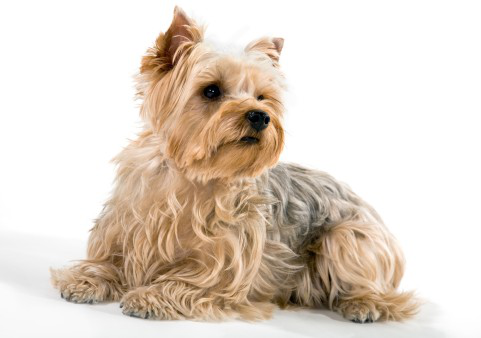

In [22]:
img = Image.open('test_imgs/yorkshire-terrier-01.jpg')
img

In [23]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor.accept = 'application/json'
predictor.content_type = 'application/json'

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

response = predictor.predict( { "url": "https://www.yourpurebredpuppy.com/dogbreeds/photos2-Y/yorkshire-terrier-01.jpg" })

print(response)

algo-1-e4rhk_1  | 2020-03-15 13:34:01,588 [INFO ] W-9005-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - generated new fontManager
algo-1-e4rhk_1  | 2020-03-15 13:34:02,342 [INFO ] W-9005-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - model_fn
algo-1-e4rhk_1  | 2020-03-15 13:34:02,343 [INFO ] W-9005-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Loading model from path: /opt/ml/model/model.pkl
algo-1-e4rhk_1  | 2020-03-15 13:34:02,444 [INFO ] W-9005-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - model loaded successfully
algo-1-e4rhk_1  | 2020-03-15 13:34:02,445 [INFO ] W-9005-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Deserializing the input data.
algo-1-e4rhk_1  | 2020-03-15 13:34:02,445 [INFO ] W-9005-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Request body is: {"url": "https://www.yourpurebredpuppy.com/dogbreeds/photos2-Y/yorkshire-terrier-01.jpg"}
algo-1-e4rhk_1  | 2020-03-15 13:34:02,445 [INFO ] W-9005-model-stdout com.a

In [24]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


# Part 2: Training and Hosting your Algorithm in Amazon SageMaker
Once you have your container packaged, you can use it to train and serve models. Let's do that with the algorithm we made above.

## Set up the environment
Here we specify the bucket to use and the role that is used for working with SageMaker.

In [6]:
# S3 prefix
prefix = 'DEMO-fastai2-oxford-pets'

## Create the session

The session remembers our connection parameters to SageMaker. We use it to perform all of our SageMaker operations.

In [25]:
import sagemaker as sage

sess = sage.Session()

## Upload the data for training

We will use the tools provided by the SageMaker Python SDK to upload the data to a default bucket.

In [8]:
data_location = sess.upload_data(path, key_prefix=prefix)

In [26]:
data_location='s3://sagemaker-eu-west-1-934676248949/DEMO-fastai2-oxford-pets'

## Training on SageMaker
Training a model on SageMaker with the Python SDK is done in a way that is similar to the way we trained it locally. This is done by changing our train_instance_type from `local` to one of our [supported EC2 instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/).

In addition, we must now specify the ECR image URL, which we just pushed above.

Finally, our local training dataset has to be in Amazon S3 and the S3 URL to our dataset is passed into the `fit()` call.

Let's first fetch our ECR image url that corresponds to the image we just built and pushed.

In [27]:
import boto3

client = boto3.client('sts')
account = client.get_caller_identity()['Account']

my_session = boto3.session.Session()
region = my_session.region_name

algorithm_name = 'fastai2-oxford-pets-sagemaker-example'

ecr_image = '{}.dkr.ecr.{}.amazonaws.com/{}-{}:latest'.format(account, region, algorithm_name, 'training')

print(ecr_image)

934676248949.dkr.ecr.eu-west-1.amazonaws.com/fastai2-oxford-pets-sagemaker-example-training:latest


In [ ]:
from sagemaker.pytorch import PyTorch

hyperparameters = {'epochs': 2}

instance_type = 'ml.p3.2xlarge'

estimator = PyTorch(source_dir='container/oxford-pets',
                    entry_point='oxford-pets.py',
                    role=role,
                    train_instance_count=1,
                    train_instance_type=instance_type,
                    framework_version='1.3.1',
                    hyperparameters=hyperparameters,
                    image_name=ecr_image)

estimator.fit(data_location)

2020-03-15 13:40:30 Starting - Starting the training job...
2020-03-15 13:40:32 Starting - Launching requested ML instances......
2020-03-15 13:41:30 Starting - Preparing the instances for training...
2020-03-15 13:42:24 Downloading - Downloading input data...............
2020-03-15 13:44:56 Training - Downloading the training image.................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-03-15 13:47:42,891 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-03-15 13:47:42,916 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.

2020-03-15 13:47:41 Training - Training image download completed. Training in progress.2020-03-15 13:47:49,148 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-03-15 13:47:49,406 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating

In [ ]:
ecr_image = '{}.dkr.ecr.{}.amazonaws.com/{}-{}:latest'.format(account, region, algorithm_name, 'inference')
print(ecr_image)

In [ ]:
model = estimator.create_model(role=role, 
                               entry_point='oxford-pets.py', 
                               source_dir='container/oxford-pets')
model.image = ecr_image
predictor = model.deploy(1, 'ml.c5.xlarge')

In [ ]:
img = Image.open('test_imgs/yorkshire-terrier-01.jpg')
img

In [ ]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor.accept = 'application/json'
predictor.content_type = 'application/json'

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

response = predictor.predict( { "url": "https://www.yourpurebredpuppy.com/dogbreeds/photos2-Y/yorkshire-terrier-01.jpg" })

print(response)

## Optional cleanup
When you're done with the endpoint, you should clean it up.

All of the training jobs, models and endpoints we created can be viewed through the SageMaker console of your AWS account.

In [ ]:
predictor.delete_endpoint()

# Reference
- [How Amazon SageMaker interacts with your Docker container for training](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html)
- [How Amazon SageMaker interacts with your Docker container for inference](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-code.html)
- [Oxford Pets Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)
- [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk)
- [Dockerfile](https://docs.docker.com/engine/reference/builder/)
- [scikit-bring-your-own](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb)
- [SageMaker PyTorch container](https://github.com/aws/sagemaker-pytorch-container)